Model development

Epoch 1/50


/opt/anaconda3/envs/trial_analytics/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.3949 - loss: nan - val_accuracy: 0.3476 - val_loss: nan
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3254 - loss: nan - val_accuracy: 0.3476 - val_loss: nan
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3504 - loss: nan - val_accuracy: 0.3476 - val_loss: nan
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3391 - loss: nan - val_accuracy: 0.3476 - val_loss: nan
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3243 - loss: nan - val_accuracy: 0.3476 - val_loss: nan
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3449 - loss: nan - val_accuracy: 0.3476 - val_loss: nan
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3375 - loss: nan - val_accuracy: 0.3476 - val_loss: nan
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3358 - loss: nan - val_accuracy: 0.3476 - val_loss: nan
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step -

/opt/anaconda3/envs/trial_analytics/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/trial_analytics/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/trial_analytics/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

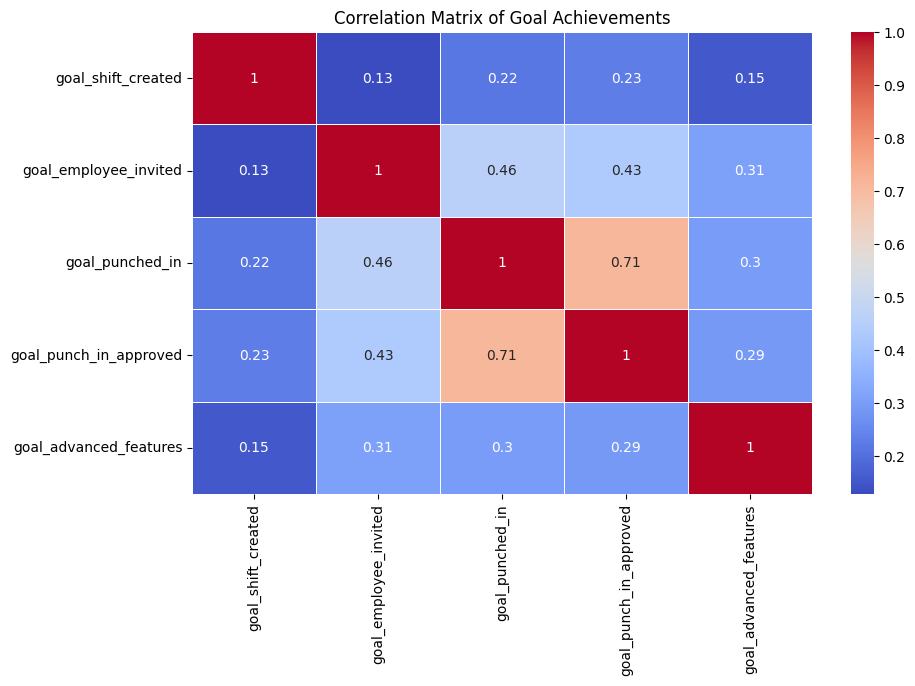

In [4]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

# Create a database connection
db_path = '../trial_data.db'
engine = create_engine(f'sqlite:///{db_path}')

# Load the goal achievement data from the trial_goals table
goal_df = pd.read_sql('SELECT * FROM trial_goals', engine)

# Convert boolean values to integers for correlation analysis and modeling
goal_df.replace({True: 1, False: 0}, inplace=True)

# Load the behavioral events data to create time-based features
behavioral_df = pd.read_sql('SELECT * FROM staging_behavioral_events', engine)
behavioral_df['timestamp'] = pd.to_datetime(behavioral_df['timestamp'])

# Create time-based features
behavioral_df['day_of_week'] = behavioral_df['timestamp'].dt.dayofweek
behavioral_df['hour_of_day'] = behavioral_df['timestamp'].dt.hour

# Aggregate time-based features per organization
time_features = behavioral_df.groupby('organization_id').agg({
    'day_of_week': ['mean', 'std'],
    'hour_of_day': ['mean', 'std'],
    'timestamp': ['min', 'max']
}).reset_index()
time_features.columns = ['organization_id', 'day_of_week_mean', 'day_of_week_std', 'hour_of_day_mean', 'hour_of_day_std', 'start_time', 'end_time']

# Calculate the duration of the trial period for each organization
time_features['trial_duration'] = (time_features['end_time'] - time_features['start_time']).dt.total_seconds() / (60 * 60 * 24)

# Merge time-based features with goal achievements
df = pd.merge(goal_df, time_features, on='organization_id')

# Define target and features
target = 'goal_shift_created'  # Assuming we are predicting shift creation; adjust as needed
features = df.drop(columns=['organization_id', target])

# Convert datetime columns to numeric
datetime_columns = features.select_dtypes(include=['datetime64']).columns
for col in datetime_columns:
    features[col] = features[col].astype(int) / 10**9  

labels = df[target]
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define a benchmark LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train_scaled.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Reshape the training data for LSTM
X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

# Train the model
model.fit(X_train_lstm, y_train, epochs=50, batch_size=32, validation_data=(X_test_lstm, y_test))

# Evaluate the model
y_pred = (model.predict(X_test_lstm) > 0.5).astype(int)
print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")

# Correlation Analysis
# Calculate the correlation matrix
numeric_columns = goal_df.select_dtypes(include=[np.number]).columns
corr_matrix = goal_df[numeric_columns].corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Goal Achievements')
plt.show()